In [1]:
import os
import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

from convolutional_ar.model import ConvAR

# Convolutional Autoregressive Model



In [2]:
# Image files
base_dir = "datasets/KTH-TIPS2-b"
f = os.listdir(base_dir)
f.sort()

In [3]:
classes = [
    'aluminium_foil',
    'brown_bread',
    'corduroy',
    'cork',
    'cotton',
    'cracker',
    'lettuce_leaf',
    'linen',
    'white_bread',
    'wood',
    'wool'
]

classes = {k: i for i, k in enumerate(classes)}
classes

{'aluminium_foil': 0,
 'brown_bread': 1,
 'corduroy': 2,
 'cork': 3,
 'cotton': 4,
 'cracker': 5,
 'lettuce_leaf': 6,
 'linen': 7,
 'white_bread': 8,
 'wood': 9,
 'wool': 10}

In [4]:
X = []
y = []

for c in tqdm(classes.keys(), total=len(classes)):
    for s in ['a', 'b', 'c', 'd']:
        for f in os.listdir(f"{base_dir}/{c}/sample_{s}/"):
            X.append(
                torchvision.transforms.Grayscale()(
                    torchvision.io.read_image(f"{base_dir}/{c}/sample_{s}/{f}")
                )[0]
            )
            y.append(classes[c])

  0%|          | 0/11 [00:00<?, ?it/s]

In [6]:
vectors = []
for x in tqdm(X, total=len(X)):

    _vectors = []
    for i in [1, 2, 3, 4, 5]:

        xf = x[::i, ::i]
        xf = x.float()
        xf = (xf - xf.mean()) / xf.std()

        car = ConvAR(6, verbose=None, n_epochs=100, lr=0.1, loss_fn=torch.nn.L1Loss())
        car.fit(xf)

        _vectors.append(car.weight_vector_.numpy())
    
    vectors.append(np.hstack(_vectors))

vectors = np.array(vectors)
vectors = vectors[:, 0, :]
np.save("vectors_kth.npy", vectors)

  0%|          | 0/4752 [00:00<?, ?it/s]

In [7]:
vectors = np.load("vectors_kth.npy")

In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(vectors, y, train_size=0.8)

# Normalize
#X_train = StandardScaler().fit_transform(X_train)
#X_test = StandardScaler().fit_transform(X_test)

# Fit SVM
svc = SVC(C=1e3, probability=True)
svc.fit(X_train, y_train)

# Accuracy
print('Train Accuracy: ', (svc.predict(X_train) == y_train).sum() / len(y_train))
print('Test  Accuracy: ', (svc.predict(X_test) == y_test).sum() / len(y_test))

Train Accuracy:  0.9813207050776112
Test  Accuracy:  0.6340694006309149


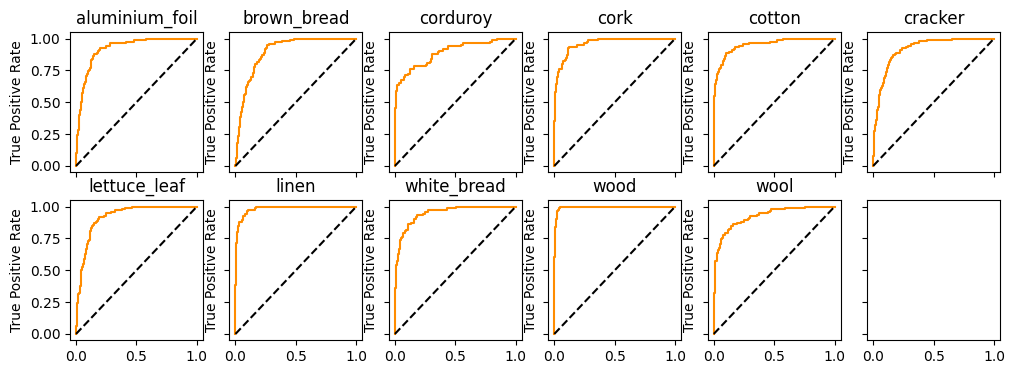

In [9]:
# Plot AUC
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)

y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

y_score = svc.predict_proba(X_test)


fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 4), sharex=True, sharey=True)
axes = axes.flatten()

for c in classes.keys():
    i = classes[c]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, i],
        y_score[:, i],
        name=f"{c} vs the rest",
        color="darkorange",
        plot_chance_level=True,
        ax=axes[i]
    )
    axes[i].set_ylabel("True Positive Rate")
    if i > 20:
        axes[i].set_xlabel("False Positive Rate") 
    else:
        axes[i].set_xlabel("")
    axes[i].get_legend().remove()
    axes[i].set_title(f"{c}")